In [1]:
import warnings
# warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import tensorflow as tf

import glob
import keras
from datetime import datetime
import time
# from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score
# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import pacf
%matplotlib inline
from matplotlib.pylab import rcParams
# import seaborn as sns
rcParams['figure.figsize']=15,5

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [3]:
# seed=1226 = 0.98
seed=1226

In [4]:
from time import time

import numpy as np
import pandas as pd


# For plotting
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import plotly.graph_objects as go

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,7)})

#For standardising the dat
from sklearn.preprocessing import StandardScaler

#PCA
from sklearn.manifold import TSNE

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense,Input,Reshape, Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
import glob
import keras
from datetime import datetime
from keras.callbacks import EarlyStopping
import time
# from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
# from sklearn.metrics import r2_score

# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats
from keras.utils import to_categorical
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import pacf
%matplotlib inline
from matplotlib.pylab import rcParams
# import seaborn as sns
rcParams['figure.figsize']=15,5




In [6]:
Stations = ['Data20Nov','Data23Nov2','Data23Nov1','Data24Nov','Data24Nov2','Data25Nov','Data29Nov','Data1Dec','Data2Dec','Data3Dec']

In [7]:
#Rearrange the Array
def makeArray(Array):
    New=np.array(Array[0])

    for i in range(1,len(Array)):
        New = np.append(New,Array[i],axis=0)
        
    return New

In [8]:
def readData(Stations):
    
    Data, C = [], []
    
#     print(Stations)
    file = Stations+'.csv'
    newfile = file
    df = pd.read_csv('dataset/'+newfile, header=0, index_col=None)
    print(newfile)
    df = df.reset_index(drop=True)
    data=df[['Present_AX','Present_Ay','Present_AZ']].values
    data=data.astype('float32')
#     data=data[:,0]**2+data[:,1]**2+data[:,2]**2
#     data=np.sqrt(data)
#     data=data.reshape((-1,1))
    count=df['Change'].values
    count=count.astype('float32')
    count=count.reshape((-1,1))

#     #Normalize the data
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     data = scaler.fit_transform(data)
    D=data[1:]-data[:-1]
    D[np.where((D[:,0]<0.01) & (D[:,0]>-0.01)),0]=0
    D[np.where((D[:,1]<0.01) & (D[:,1]>-0.01)),1]=0
    D[np.where((D[:,2]<0.01) & (D[:,2]>-0.01)),2]=0
    print(D.shape)
    Data.append(D)
    C.append(count[1:])
           
    
        
    return makeArray(Data), makeArray(C)



In [9]:
Data=[[] for x in range(len(Stations))]
Count=[[] for x in range(len(Stations))]
for i in range(len(Stations)):
    Data[i], Count[i] = readData(Stations[i])

Data20Nov.csv
(28698, 3)
Data23Nov2.csv
(44971, 3)
Data23Nov1.csv
(13356, 3)
Data24Nov.csv
(9226, 3)
Data24Nov2.csv
(18082, 3)
Data25Nov.csv
(12493, 3)
Data29Nov.csv
(16509, 3)
Data1Dec.csv
(3160, 3)
Data2Dec.csv
(3566, 3)
Data3Dec.csv
(1771, 3)


In [10]:
for i in range(10):
    print(Data[i].shape)

(28698, 3)
(44971, 3)
(13356, 3)
(9226, 3)
(18082, 3)
(12493, 3)
(16509, 3)
(3160, 3)
(3566, 3)
(1771, 3)


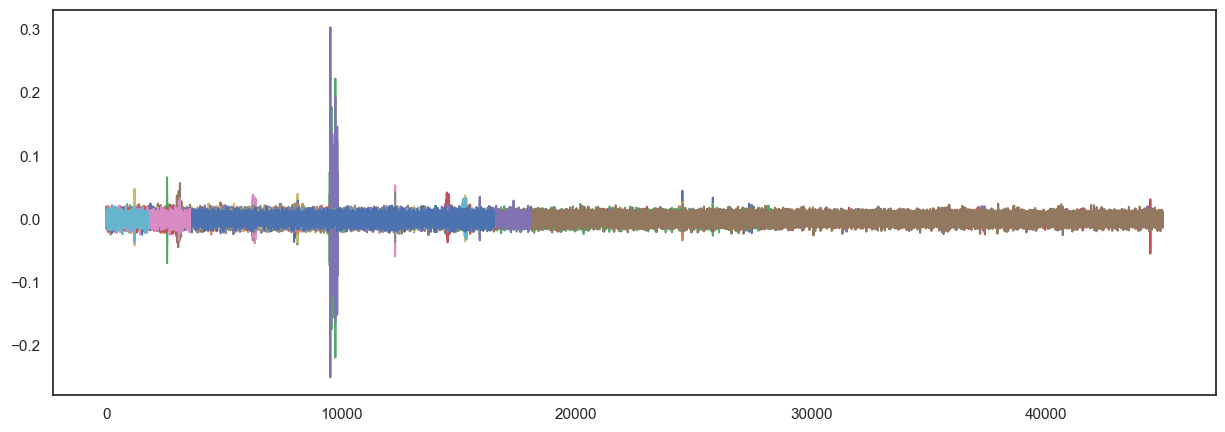

In [11]:
for i in range(10):
    plt.plot(Data[i])


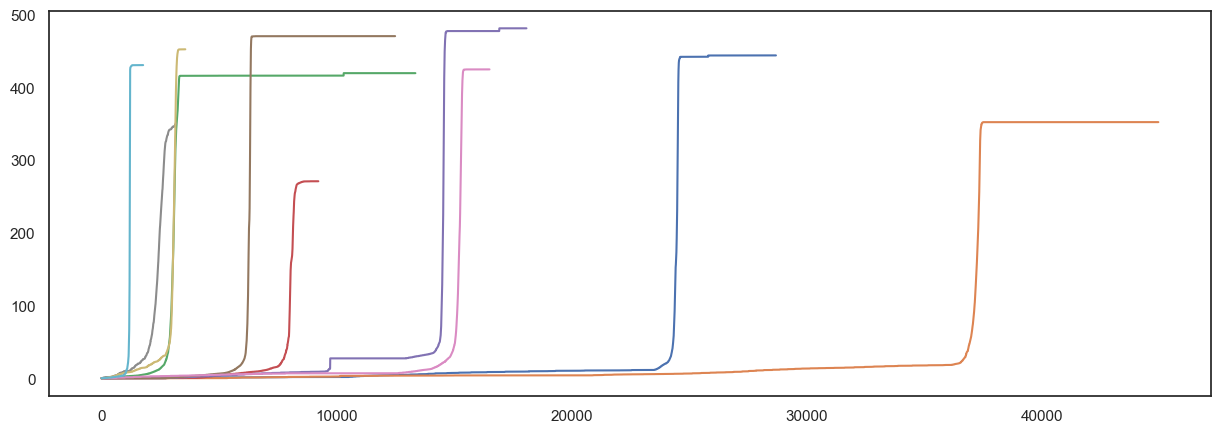

In [12]:
for i in range(10):
    plt.plot(np.cumsum(Count[i]))


In [13]:
def makePacket(data,label,lag):
    D,L=[],[]
    length=len(data)
    for i in range(length-lag+1):
        D.append(data[i:lag+i,:])
#         S=label[lag+i-1]-label[i]
        L.append(label[i:lag+i,:])
        
    return np.array(D),np.array(L)
        
   

In [14]:
DD=np.zeros(10)
LL=np.zeros(10)
for i in range(10):
    DD[i]=i
    LL[i]=i
DD=DD.reshape((-1,1))   
LL=LL.reshape((-1,1))  

In [15]:
D,L=makePacket(Data[0],Count[0],3)

In [16]:
D.shape

(28696, 3, 3)

In [17]:
L.shape

(28696, 3, 1)

In [18]:
def positional_encoding(length, depth):
    dim=depth
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 
    

    return pos_encoding

In [19]:
# #@title
# pos_encoding = positional_encoding(length=2048, depth=512)

# # Check the shape.
# print(pos_encoding.shape)

# # Plot the dimensions.
# plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
# plt.ylabel('Depth')
# plt.xlabel('Position')
# plt.colorbar()
# plt.show()

In [20]:
# #@title
# pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
# p = pos_encoding[1000]
# dots = tf.einsum('pd,d -> p', pos_encoding, p)
# plt.subplot(2,1,1)
# plt.plot(dots)
# plt.ylim([0,1])
# plt.plot([950, 950, float('nan'), 1050, 1050],
#          [0,1,float('nan'),0,1], color='k', label='Zoom')
# plt.legend()
# plt.subplot(2,1,2)
# plt.plot(dots)
# plt.xlim([950, 1050])
# plt.ylim([0,1])


In [21]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model,length=2048,lag=1):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.dense1 = tf.keras.layers.Dense(d_model) 
        self.dense2 = tf.keras.layers.Dense(d_model) 
        self.pos_encoding = positional_encoding(length=length, depth=d_model,lag=lag)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, A, B, lag):
        length = tf.shape(A)[0]
#         x = self.embedding(x)
        
        x=self.dense1(A)
       
        y=self.dense2(B)
#         print(x.shape)
#         print(x)
#         print(self.pos_encoding[tf.newaxis, :length, :].shape)
        # This factor sets the relative scale of the embedding and positonal_encoding.
#         print(y.shape)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[ :length, :]
        y *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        y = y + self.pos_encoding[ :length, :]
#         print(y.shape)
        
#         D,L=makePacket(x,y,lag)
        return x,y


In [22]:
en=Data[9]
pt=Count[9]

In [23]:
en.shape

(1771, 3)

In [24]:
pt.shape

(1771, 1)

In [25]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [26]:
def custom_loss_function(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

In [27]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [28]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [29]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
#         print(x.shape)
        attn_output = self.mha(query=x, value=x, key=x)
#         print(attn_output)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [30]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
#         print('causal',x.shape)
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            )
#         print('exit')
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x

In [31]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model, activation='relu'),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
#         x = self.seq(x)
        x = self.layer_norm(x) 
        return x


In [32]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [33]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

#         self.pos_embedding = PositionalEmbedding(
#             vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
#         x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

# #         Add dropout.
        x = self.dropout(x)
#         print('encoder: ',end='')
#         print(x.shape)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [34]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [35]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

#         self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
#                                                  d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                         dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
#         x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

#         x = self.dropout(x)
#         print('decoder: ',end='')
#         print(x.shape)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [36]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(3,name='last')
        self.input1=tf.keras.layers.Input(shape=(3,3,))
        self.two=tf.keras.layers.Flatten()
        self.three=tf.keras.layers.Dense(10000, activation='relu',name='three')
        self.three1=tf.keras.layers.Dense(1000, activation='relu', name='three1')
        self.four=tf.keras.layers.Dense(1, activation='relu',name='four')
        self.out=0

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context  = inputs
        context = self.encoder(context)  # (batch_size, context_len, d_model)
        x = self.two(context)
        x = self.three(x)
        x = self.three1(x)
        logits = self.four(x)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits
    

In [42]:
lag=3
num_layers = 5
d_model = 9
dff = 1000
num_heads = 20
dropout_rate = 0.1

In [43]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=500,
    target_vocab_size=1,
    dropout_rate=dropout_rate)

In [44]:
learning_rate = CustomSchedule(d_model)
# learning_rate = 0.1
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-4)
transformer.compile(loss='mse', optimizer=optimizer)

In [45]:
def createData(Data, Count, lag):
    z=np.zeros((Data.shape[0],1))
    v=np.zeros((Data.shape[0],3))
    new=np.hstack((Data,z))
    lbl=np.hstack((Count,v))
    D,L=makePacket(new, lbl,lag)
    pos_encoding = positional_encoding(length=new.shape[0], depth=4)
    pos_encoding2 = positional_encoding(length=new.shape[0], depth=4)
#     new=new+pos_encoding
    label=lbl[:,0].reshape((-1,1))
    _,label=makePacket(new[:,:-1], label.reshape((-1,1)),lag)
    lbl=lbl+pos_encoding2
    D,L=makePacket(new[:,:-1], lbl[:,:-1],lag)
    label=Count[lag-1:].reshape((-1,1,1))
    return D, label

In [46]:
AllData, Alllabel = [], []
for i in range(9,10):
    print(i)
    D,L = createData(Data[i],Count[i],lag)
    AllData.append(D)
    Alllabel.append(L)

9


In [48]:
D=D.reshape((-1,9))

In [53]:
D.shape,L.shape

((1769, 9), (1769, 1, 1))

In [50]:
E=AllData[0]
F=Alllabel[0]
for i in range(1,1):
    E=np.vstack((E,AllData[i]))
    F=np.vstack((F,Alllabel[i]))

In [51]:
E.shape,F.shape

((1769, 3, 3), (1769, 1, 1))

In [54]:
A=en[:10]
B=pt[:10]
A=D
B=L

output1 = transformer((A))
output1.shape

IndexError: Exception encountered when calling layer "softmax" (type Softmax).

tuple index out of range

Call arguments received by layer "softmax" (type Softmax):
  • inputs=tf.Tensor(shape=(1769, 20), dtype=float32)
  • mask=None

In [345]:
transformer.summary()

Model: "transformer_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_9 (Encoder)         multiple                  39590     
                                                                 
 last (Dense)                multiple                  0 (unused)
                                                                 
 flatten_11 (Flatten)        multiple                  0         
                                                                 
 three (Dense)               multiple                  1510000   
                                                                 
 three1 (Dense)              multiple                  10001000  
                                                                 
 four (Dense)                multiple                  1001      
                                                                 
Total params: 11,551,591
Trainable params: 11,551,591

In [346]:
Input=(E)

In [347]:
target=F

In [348]:
callbacks = [keras.callbacks.EarlyStopping(monitor='loss',patience=10, restore_best_weights=True)]

In [349]:
transformer.fit(Input,target.reshape((-1,1)),epochs=10000,batch_size=1024, callbacks=callbacks)

Epoch 1/10000
2/2 [==============================] - 10s 3s/step - loss: 2.6068
Epoch 2/10000
2/2 [==============================] - 5s 2s/step - loss: 2.6079
Epoch 3/10000
2/2 [==============================] - 5s 2s/step - loss: 2.5970
Epoch 4/10000
2/2 [==============================] - 4s 1s/step - loss: 2.5850
Epoch 5/10000
2/2 [==============================] - 4s 1s/step - loss: 2.5338
Epoch 6/10000
2/2 [==============================] - 4s 1s/step - loss: 2.4655
Epoch 7/10000
2/2 [==============================] - 4s 1s/step - loss: 2.3754
Epoch 8/10000
2/2 [==============================] - 3s 1s/step - loss: 2.2756
Epoch 9/10000
2/2 [==============================] - 3s 1s/step - loss: 2.1579
Epoch 10/10000
2/2 [==============================] - 3s 1s/step - loss: 2.0151
Epoch 11/10000
2/2 [==============================] - 3s 1s/step - loss: 1.8338
Epoch 12/10000
2/2 [==============================] - 3s 1s/step - loss: 1.6848
Epoch 13/10000
2/2 [============================

54/54 [==============================] - 7s 102ms/step


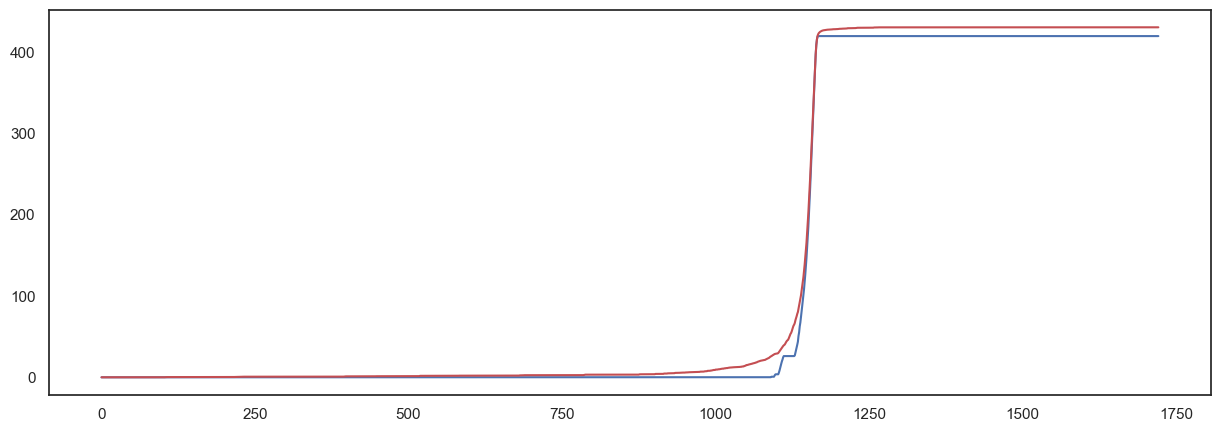

In [350]:
for i in range(1):
    A=AllData[i]
    B=Alllabel[i]
    P=transformer.predict(A)
    plt.plot(np.cumsum(P),color='b')
    plt.plot(np.cumsum(B),color='r')
    plt.show()

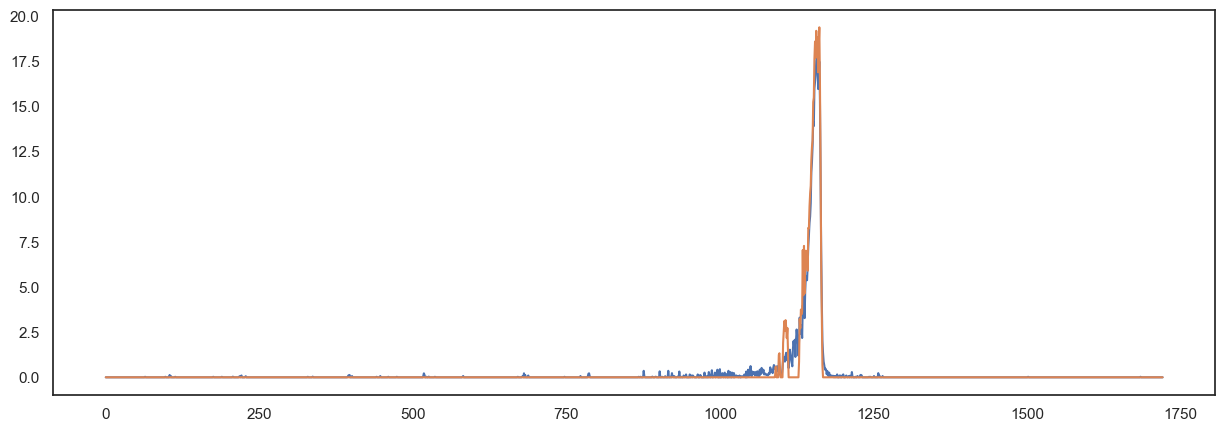

In [351]:
plt.plot(B.reshape((-1,1)))
plt.plot(P)


In [196]:
E.shape

(1768, 4, 3)

In [197]:
from tensorflow.keras import datasets, layers, models

In [198]:
model = models.Sequential()
model.add(layers.Conv2D(128, (2, 2), activation='relu', padding='same', input_shape=(4, 3, 1)))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (2,2), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='relu'))

In [199]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 4, 3, 128)         640       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 1, 128)        0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 256)               0         
                                                                 
 dense_42 (Dense)            (None, 64)                16448     
                                                                 
 dense_43 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17,153
Trainable params: 17,153
Non-trainable params: 0
_________________________________________________

In [200]:
model.compile(optimizer='adam',loss='mse')
callbacks = [keras.callbacks.EarlyStopping(monitor='loss',patience=10, restore_best_weights=True)]
history = model.fit(E, target.reshape((-1,1)), epochs=1000,callbacks=[callbacks])

Epoch 1/1000
56/56 [==============================] - 1s 12ms/step - loss: 2.5076
Epoch 2/1000
56/56 [==============================] - 0s 5ms/step - loss: 2.4876
Epoch 3/1000
56/56 [==============================] - 0s 5ms/step - loss: 2.4735
Epoch 4/1000
56/56 [==============================] - 0s 5ms/step - loss: 2.4288
Epoch 5/1000
56/56 [==============================] - 0s 5ms/step - loss: 2.4262
Epoch 6/1000
56/56 [==============================] - 0s 5ms/step - loss: 2.3542
Epoch 7/1000
56/56 [==============================] - 0s 5ms/step - loss: 2.2525
Epoch 8/1000
56/56 [==============================] - 0s 5ms/step - loss: 2.0788
Epoch 9/1000
56/56 [==============================] - 0s 5ms/step - loss: 1.8122
Epoch 10/1000
56/56 [==============================] - 0s 5ms/step - loss: 1.4587
Epoch 11/1000
56/56 [==============================] - 0s 5ms/step - loss: 1.1922
Epoch 12/1000
56/56 [==============================] - 0s 5ms/step - loss: 1.0179
Epoch 13/1000
56/56 [===

Epoch 101/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.5758
Epoch 102/1000
56/56 [==============================] - 0s 4ms/step - loss: 0.5656
Epoch 103/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.5713
Epoch 104/1000
56/56 [==============================] - 0s 4ms/step - loss: 0.5651
Epoch 105/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.5670
Epoch 106/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.5483
Epoch 107/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.5524
Epoch 108/1000
56/56 [==============================] - 0s 4ms/step - loss: 0.5391
Epoch 109/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.5414
Epoch 110/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.5631
Epoch 111/1000
56/56 [==============================] - 0s 4ms/step - loss: 0.5489
Epoch 112/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.5706
Epoc

56/56 [==============================] - 0s 2ms/step


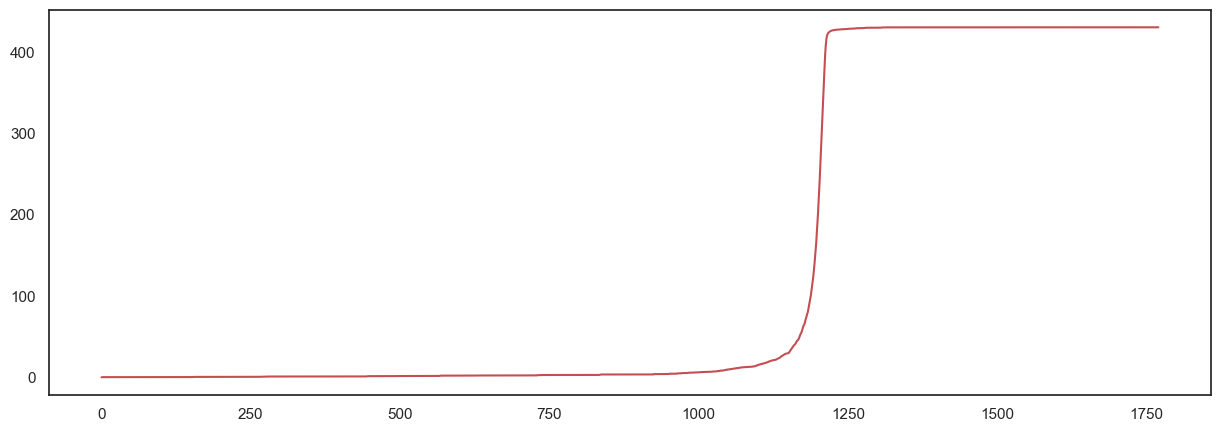

In [252]:
P=model.predict(E)
plt.plot(np.cumsum(P),color='b')
plt.plot(np.cumsum(target),color='r')

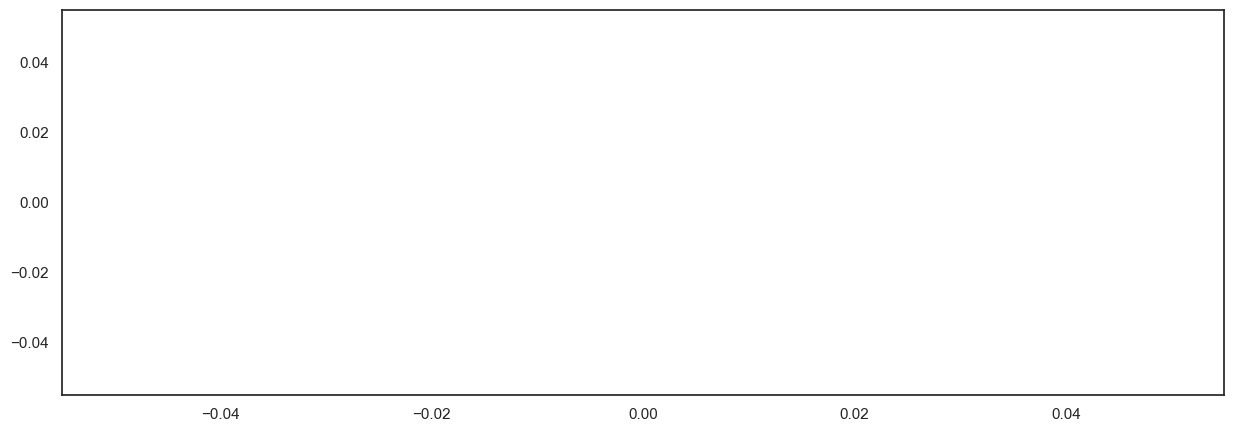

In [251]:
plt.plot(P,color='b')
plt.plot(target.reshape((-1,1)),color='r')